In [1]:
import os 
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def readImages(dataset_Folder):
    images = []
    foldernames = []
    for foldername in os.listdir(dataset_Folder):
        foldernames.append(foldername)
        foldername_images = []
        for filename in os.listdir(dataset_Folder + "/" + foldername):
            img = cv2.imread(dataset_Folder + "/" + foldername + "/" + filename,0)
            foldername_images.append(img)
        images.append(np.array(foldername_images))

    return np.array(images),foldernames

In [3]:
images , folder_names= readImages("dataset")

C:\Users\burak\AppData\Local\Temp\ipykernel_21276\2779168219.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images),foldernames


In [4]:
def SaveMatches(img,foldername,i):
    dir = os.path.join(os.getcwd(),"matches")
    if not os.path.exists(dir):
        os.mkdir(dir)
    cv2.imwrite(os.path.join(dir,"match_"+foldername+"_"+str(i)+".jpg"),img)


def Extract_Feature(img):
    
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    
    fig = plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(img,cmap="gray")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.drawKeypoints(img, kp, None))
    

def Extract_Match(img1, img2,foldername,i):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher()

    matches = bf.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.3 * n.distance:
            good_matches.append(m)

    good_matches = sorted(good_matches, key=lambda x: x.distance)

    similar_points = []
    for match in good_matches:
        query_idx = match.queryIdx
        train_idx = match.trainIdx
 
        point1 = kp1[query_idx].pt
        point2 = kp2[train_idx].pt

        similar_points.append((point1, point2))

    img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    SaveMatches(img3,foldername,i)

    return np.array(similar_points)
    
def get_inliers(points1, points2, homography_matrix, threshold):
    inliers = []
    for i in range(len(points1)):
        x1, y1 = points1[i]
        x2, y2 = points2[i]
        point1 = np.array([x1, y1, 1])
        transformed_point2 = homography_matrix.dot(point1)
        transformed_point2 /= transformed_point2[2]
        error = np.sqrt((x2 - transformed_point2[0]) ** 2 + (y2 - transformed_point2[1]) ** 2)
        if error < threshold:
            inliers.append(i)

    return inliers

def calculate_homography(points1, points2):
    A = []
    for i in range(len(points1)):
        x1, y1 = points1[i]
        x2, y2 = points2[i]
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    homography_matrix = V[-1].reshape(3, 3)
    # normalize matrix so that h33 = 1
    homography_matrix = homography_matrix / homography_matrix[-1, -1]
    return homography_matrix
    
def calculate_homography_matrix(points1, points2, num_iterations, threshold):
    best_inliers = []
    best_homography_matrix = None

    for _ in range(num_iterations):
        # Randomly select four point correspondences
        random_indices = np.random.choice(len(points1), 4, replace=False)
        random_points1 = points1[random_indices]
        random_points2 = points2[random_indices]

        # Calculate the homography matrix using the selected points

        homography_matrix = calculate_homography(random_points1, random_points2)
        

        # Calculate the inliers using the current homography matrix
        inliers = get_inliers(points1, points2, homography_matrix, threshold)

        # Update the best homography matrix and inliers if the current set has more inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_homography_matrix = homography_matrix

    return best_homography_matrix




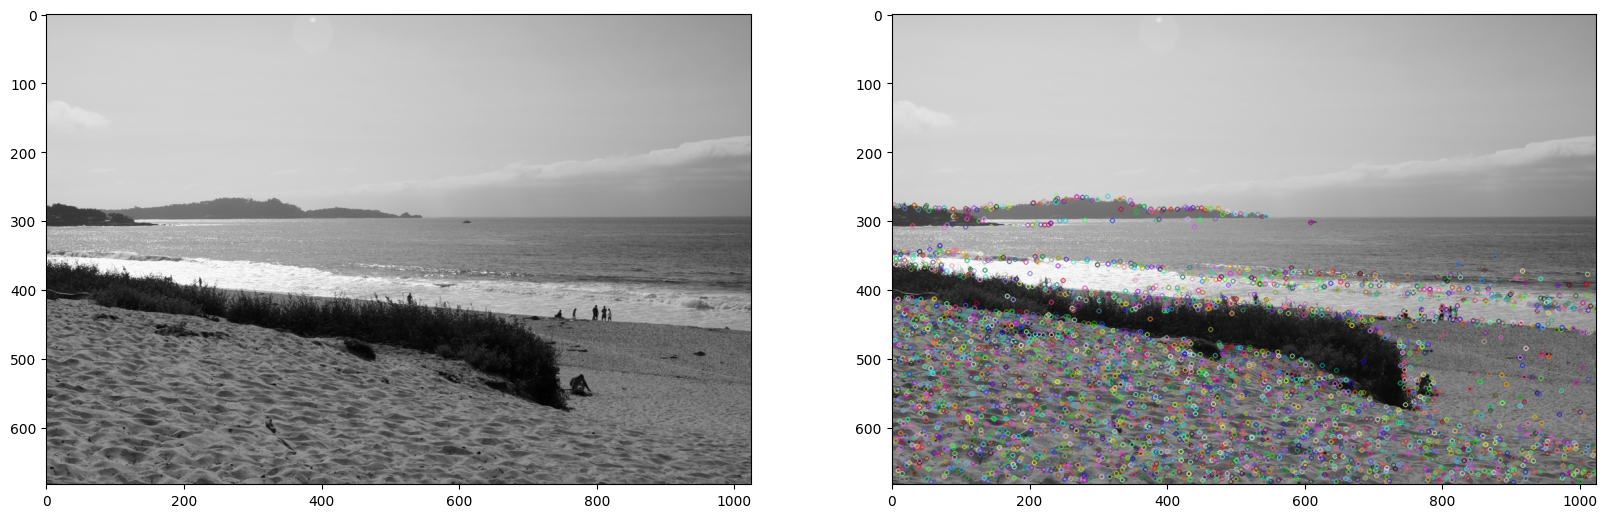

In [5]:

Extract_Feature(images[0][0])

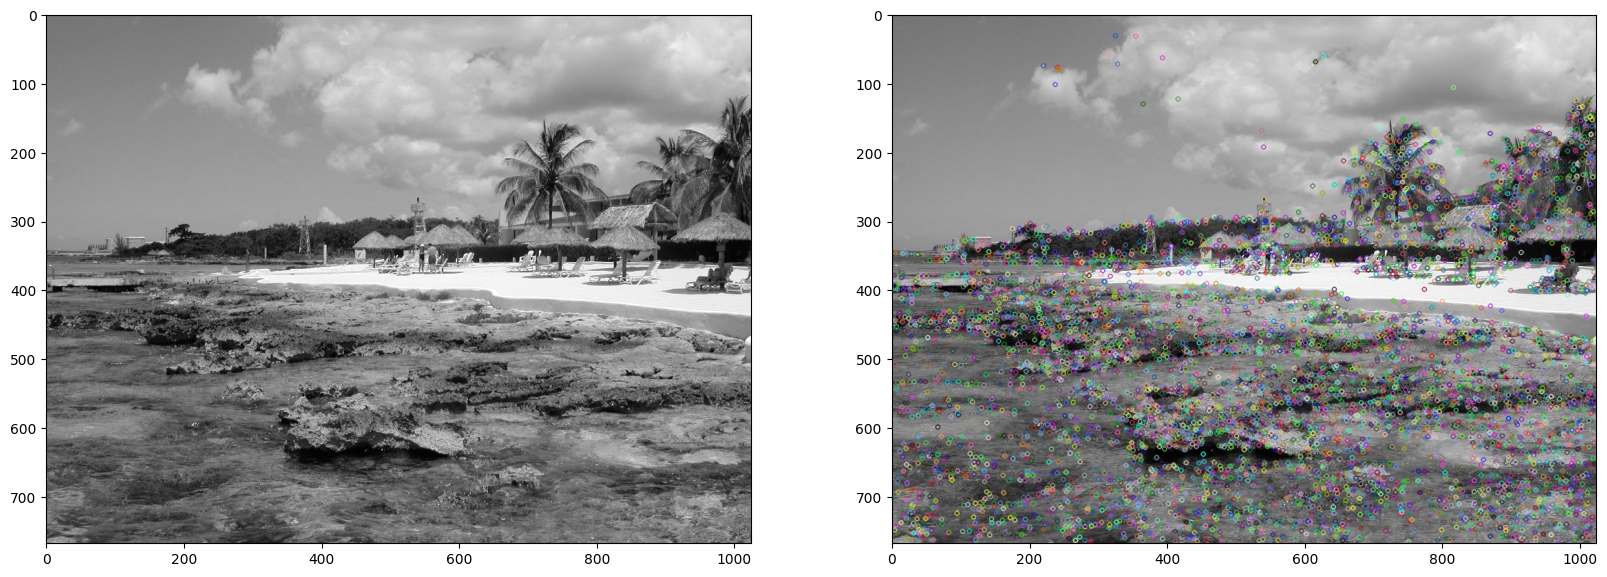

In [6]:
Extract_Feature(images[3][1])

In [74]:
for i in range(len(images)):
    print("Extracting Matches for Folder: ",folder_names[i])
    for j in range(len(images[i])-1):
        similar_points = Extract_Match(images[i][j],images[i][j+1],folder_names[i],j)
        hom_matrix = calculate_homography_matrix(similar_points[:,0],similar_points[:,1],100,10)
        print("Homography Matrix between images: ",j+1," and ",j+2," is: \n",hom_matrix)
    
    print("\n\n")
        

Extracting Matches for Folder:  carmel
Homography Matrix between images:  1  and  2  is: 
 [[ 1.03623113e+00 -9.96844334e-03 -2.75051847e+02]
 [ 2.96712600e-02  9.29208300e-01  2.09138117e+01]
 [ 1.02556102e-04 -1.25425030e-04  1.00000000e+00]]
Homography Matrix between images:  2  and  3  is: 
 [[ 1.09980326e+00 -8.00207307e-03 -3.05359285e+02]
 [ 2.32155394e-02  1.07879501e+00 -3.25195631e+01]
 [ 9.36062776e-05  5.48303106e-06  1.00000000e+00]]
Homography Matrix between images:  3  and  4  is: 
 [[ 1.10475020e+00 -1.91116322e-02 -2.95542179e+02]
 [ 1.89201925e-02  1.10666886e+00 -3.59217039e+01]
 [ 7.36970449e-05  4.51333975e-05  1.00000000e+00]]
Homography Matrix between images:  4  and  5  is: 
 [[ 1.14559987e+00 -1.00770657e-03 -3.69465282e+02]
 [ 2.46024191e-02  1.11957405e+00 -4.10534755e+01]
 [ 1.36020684e-04  1.29301787e-05  1.00000000e+00]]
Homography Matrix between images:  5  and  6  is: 
 [[ 1.09369131e+00  3.95126995e-03 -3.36993728e+02]
 [ 1.58211023e-02  1.08387689e+00 